In [101]:
import pandas as pd
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [102]:
path = "/content/drive/MyDrive/Tweets.csv"
df = pd.read_csv(path)
df.head()

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,5.703060e+17,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,24-02-2015 11:35,NaN,Eastern Time (US & Canada)
1,5.703010e+17,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,24-02-2015 11:15,NaN,Pacific Time (US & Canada)
2,5.703010e+17,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,24-02-2015 11:15,Lets Play,Central Time (US & Canada)
3,5.703010e+17,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,24-02-2015 11:15,NaN,Pacific Time (US & Canada)
4,5.703010e+17,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,24-02-2015 11:14,NaN,Pacific Time (US & Canada)


**Only text and sentiment columns are required**

In [103]:
imp_df = df[['text','airline_sentiment']]

print(imp_df.shape)
imp_df.head()

(14640, 2)


,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative


In [104]:
df.columns

Index(['tweet_id', 'airline_sentiment', 'airline_sentiment_confidence',
       'negativereason', 'negativereason_confidence', 'airline',
       'airline_sentiment_gold', 'name', 'negativereason_gold',
       'retweet_count', 'text', 'tweet_coord', 'tweet_created',
       'tweet_location', 'user_timezone'],
      dtype='object')

**Neutral values are not required as we are doing binary classification**

In [105]:
imp_df = imp_df[imp_df['airline_sentiment'] != 'neutral']
print(imp_df.shape)
imp_df.head()

(11541, 2)


,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive


In [106]:
imp_df["airline_sentiment"].value_counts()

negative    9178
positive    2363
Name: airline_sentiment, dtype: int64

**Dealing with categorical values and converting them into numeric**

In [107]:
sentiment_label = imp_df.airline_sentiment.factorize()
sentiment_label

(array([0, 1, 1, ..., 0, 1, 1]),
 Index(['positive', 'negative'], dtype='object'))

In [108]:
# positive: 0, negative: 1
tweet = imp_df.text.values

**Creating small tokens of words from sentences**

In [109]:
from tensorflow.keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer(num_words=5000)
tokenizer.fit_on_texts(tweet)

**After binding the words with their assigned numbers, we replace the words with their assigned numbers**

In [110]:
encoded_docs = tokenizer.texts_to_sequences(tweet)

**Padding the sentences to make them of equal length**

In [111]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
padded_sequence = pad_sequences(encoded_docs, maxlen=200)

**Regularisation to avoid overfitting**

In [112]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM,Dense, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Embedding

In [113]:
embedding_vector_length = 32
vocab_size = len(tokenizer.word_index) + 1
model = Sequential()
model.add(Embedding(vocab_size, embedding_vector_length, input_length=200))
model.add(SpatialDropout1D(0.25))
model.add(LSTM(50, dropout=0.5, recurrent_dropout=0.5))
model.add(Dropout(0.2))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy',optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_9 (Embedding)     (None, 200, 32)           423488    
                                                                 
 spatial_dropout1d_9 (Spatia  (None, 200, 32)          0         
 lDropout1D)                                                     
                                                                 
 lstm_9 (LSTM)               (None, 50)                16600     
                                                                 
 dropout_9 (Dropout)         (None, 50)                0         
                                                                 
 dense_9 (Dense)             (None, 1)                 51        
                                                                 
Total params: 440,139
Trainable params: 440,139
Non-trainable params: 0
_______________________________________________

**Training the model**

In [114]:
history = model.fit(padded_sequence,sentiment_label[0],validation_split=0.3, epochs=8, batch_size=32)

Epoch 1/8
253/253 [==============================] - 40s 149ms/step - loss: 0.4267 - accuracy: 0.8221 - val_loss: 0.2209 - val_accuracy: 0.9134
Epoch 2/8
253/253 [==============================] - 37s 148ms/step - loss: 0.2344 - accuracy: 0.9080 - val_loss: 0.1709 - val_accuracy: 0.9353
Epoch 3/8
253/253 [==============================] - 37s 148ms/step - loss: 0.1722 - accuracy: 0.9382 - val_loss: 0.1679 - val_accuracy: 0.9368
Epoch 4/8
253/253 [==============================] - 39s 152ms/step - loss: 0.1387 - accuracy: 0.9465 - val_loss: 0.1778 - val_accuracy: 0.9362
Epoch 5/8
253/253 [==============================] - 38s 149ms/step - loss: 0.1177 - accuracy: 0.9565 - val_loss: 0.1869 - val_accuracy: 0.9396
Epoch 6/8
253/253 [==============================] - 38s 150ms/step - loss: 0.0986 - accuracy: 0.9622 - val_loss: 0.1993 - val_accuracy: 0.9368
Epoch 7/8
253/253 [==============================] - 37s 148ms/step - loss: 0.0854 - accuracy: 0.9689 - val_loss: 0.2007 - val_accuracy:

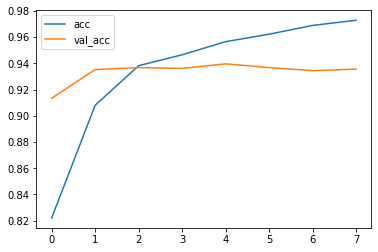

<Figure size 432x288 with 0 Axes>

In [115]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='acc')
plt.plot(history.history['val_accuracy'], label='val_acc')
plt.legend()
plt.show()
plt.savefig("Accuracy Plot.jpg")

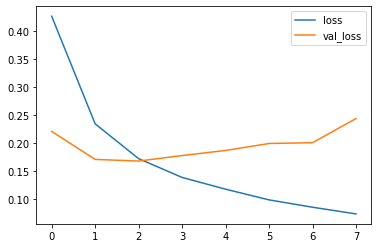

<Figure size 432x288 with 0 Axes>

In [116]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()
plt.show()
plt.savefig("Loss Plot.jpg")

**Predicting the sentiment of sentences**

In [119]:
def predict_sentiment(text):
    tw = tokenizer.texts_to_sequences([text])
    tw = pad_sequences(tw,maxlen=200)
    prediction = int(model.predict(tw).round().item())
    print("Predicted Label: ", sentiment_label[1][prediction])
test_sentence1 = "I love going to theme parks and fun fairs."
print("Sentence 1: ", test_sentence1)
predict_sentiment(test_sentence1)
test_sentence2 = "Traffic noise makes me frustrated and angry."
print("Sentence 2: ", test_sentence2)
predict_sentiment(test_sentence2)

Sentence 1:  I love going to theme parks and fun fairs.
Predicted Label:  positive
Sentence 2:  Traffic noise makes me frustrated and angry.
Predicted Label:  negative
